# Data preparation

### Setup

In [5]:
# Imports
from tqdm import tqdm
import requests
import pandas as pd
import json
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('src')
import data_utils
import analyse_utils

## Querying data

This section contains database queries and the handling of them.

### OrthoDB

API-documentation: https://www.ezlab.org/orthodb_userguide.html#api

Ortho DB groups:
- [histone H1.0](https://www.orthodb.org/?query=19111at9604)
    - 5363206at2759 at Eukaryota level
    - 2491618at33208 at Metazoa level
    - 1590200at7742 at Vertebrata level
    - 1033145at32523 at Tetrapoda level
    - 21759at40674 at Mammalia level
    - 97195at9347 at Eutheria level
    - 97195at314146 at Euarchontoglires level
    - 97195at9443 at Primates level
    - 19111at314295 at Hominoidea level (1)
    - 19111at9604 at Hominidae level (2)

In [34]:
# Setting Ortho DB group to query
group = '5363206at2759'

# Defining filename for output
filename = 'exp/ortho_h1-0/H1-0_orthodb.json'

In [5]:
# Querying API
url = f"https://data.orthodb.org/current/orthologs?id={group}"
response = requests.get(url)
data = response.json()

In [6]:
# Saving to metadata
with open(filename, 'w') as file:
    json.dump(data, file, indent=4)

## Getting template metadata

This section uses general code blocks to prepare template metadata in experiment .json files.

Fetching metadata requires a starting metadata .json file containing UniProt IDs (See `~/exp/README.md`).
Custom IDs can be arbitrary, and may be reassigned during the following procedures.

#### How to get template metadata
1. **Specify experiment**
2. **Specify templates**
3. **Get metadata**
4. **Format custom protein IDs** (_Optional_)
5. **Save metadata**

#### 1. Experiment name

In [29]:
experiment = 'initial'

In [61]:
experiment = 'ortho_h1-0'

In [2]:
experiment = 'para_h1'

#### 2. Specify templates

In [65]:
# Getting template UniProt IDs by experiment-specific methods

if experiment == 'initial':
    # Manual entries
    uids = ['P07305', 'B4DR52']
    ids = ['H1-0', 'H2B']

elif experiment == 'ortho_h1-0':
    # Entries from OrthoDB
    with open('exp/ortho_h1-0/H1-0_orthodb.json') as file:
        data = json.load(file)

    uids = []
    uids_species = []
    no_uids_ids = []
    no_uids_species = []

    # Extracting UniProt IDs
    for id in range(len(data['data'])):
        try:
            for protein in data['data'][id]['genes']:
                uids.append(protein['uniprot']['id'])
                uids_species.append(data['data'][id]['organism']['name'])
        except KeyError:
            no_uids_ids.append(data['data'][id]['genes'][0]['gene_id']['param'])
            no_uids_species.append(data['data'][id]['organism']['name']) # Skipping species without UniProt entries

    # Handling proteins with no UniProt IDs
    if no_uids_species:
        print(f"The following {len(no_uids_species)}/{len(data['data'])} entries had no UniProt IDs")
        print(*[f" - {specie}" for specie in no_uids_species], sep="\n")

    ids = list(range(len(uids)))


The following 319/485 entries had no UniProt IDs
 - Cyprinodon tularosa
 - Gambusia affinis
 - Girardinichthys multiradiatus
 - Nematolebias whitei
 - Poecilia formosa
 - Poecilia reticulata
 - Xiphophorus hellerii
 - Archocentrus centrarchus
 - Simochromis diagramma
 - Acanthopagrus latus
 - Alosa alosa
 - Alosa sapidissima
 - Anarrhichthys ocellatus
 - Anguilla anguilla
 - Boleophthalmus pectinirostris
 - Cheilinus undulatus
 - Chelmon rostratus
 - Colossoma macropomum
 - Coregonus clupeaformis
 - Cyclopterus lumpus
 - Cyprinus carpio
 - Denticeps clupeoides
 - Echeneis naucrates
 - Electrophorus electricus
 - Epinephelus lanceolatus
 - Erpetoichthys calabaricus
 - Etheostoma cragini
 - Etheostoma spectabile
 - Gadus morhua
 - Gasterosteus aculeatus aculeatus
 - Gouania willdenowi
 - Hippoglossus hippoglossus
 - Hippoglossus stenolepis
 - Hypomesus transpacificus
 - Lates calcarifer
 - Lepisosteus oculatus
 - Megalobrama amblycephala
 - Megalops cyprinoides
 - Micropterus dolomieu
 -

In [71]:
# Attempting to BLAST for new/existing UniProt entries where none were found
seqs = []
for id in tqdm(no_uids_ids):
    url = f"https://data.orthodb.org/current/fasta?id={id}"
    response = requests.get(url)
    seqs.append(data.text.split('\n')[1])
print(len(seqs))
print(len(set(seqs)))

 47%|████▋     | 149/319 [00:22<00:25,  6.65it/s]

In [ ]:
# Loading into metadata with arbitrary custom IDs
metadata_path = f'exp/{experiment}/{experiment}.json'
metadata = {'templates': {id: {"uniprot_id": uniprot_id} for uniprot_id, id in zip(uids, ids)}}
with open(metadata_path, 'w') as file:
    json.dump(metadata, file, indent=4)

#### 3. Get template metadata

In [5]:
# Getting experiment json
metadata_path = f'exp/{experiment}/{experiment}.json'
with open(metadata_path, 'r') as file:
    metadata = json.load(file)

# Getting names, descriptions, and species
deleted_records = []
for id, fields in tqdm(metadata['templates'].items()):
    uniprot_id = fields['uniprot_id']
    try:
        name, desc, spec, seq = data_utils.get_protein_metadata(uniprot_id)
    except ValueError:
        deleted_records.append(id)
        continue
    metadata['templates'][id] = {'uniprot_id': uniprot_id, 'name': name, 'description': desc, 'species': spec, 'sequence': seq}

# Discarding deleted UniProt records
if deleted_records:
    print(f"The UniProt IDs returned no records:")
    for id in deleted_records:
        print(f" - {metadata['templates'][id]['uniprot_id']}")
        del metadata['templates'][id]

pd.DataFrame(metadata['templates']).transpose()

100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


,uniprot_id,name,description,species,sequence
H1-0,P07305,H10_HUMAN,Histone H1.0,Homo sapiens (Human),MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
H1-1,Q02539,H11_HUMAN,Histone H1.1,Homo sapiens (Human),MSETVPPAPAASAAPEKPLAGKKAKKPAKAAAASKKKPAGPSVSEL...
H1-2,P16403,H12_HUMAN,Histone H1.2,Homo sapiens (Human),MSETAPAAPAAAPPAEKAPVKKKAAKKAGGTPRKASGPPVSELITK...
H1-3,P16402,H13_HUMAN,Histone H1.3,Homo sapiens (Human),MSETAPLAPTIPAPAEKTPVKKKAKKAGATAGKRKASGPPVSELIT...
H1-4,P10412,H14_HUMAN,Histone H1.4,Homo sapiens (Human),MSETAPAAPAAPAPAEKTPVKKKARKSAGAAKRKASGPPVSELITK...
H1-5,P16401,H15_HUMAN,Histone H1.5,Homo sapiens (Human),MSETAPAETATPAPVEKSPAKKKATKKAAGAGAAKRKATGPPVSEL...
H1-6,P22492,H1T_HUMAN,Histone H1t,Homo sapiens (Human),MSETVPAASASAGVAAMEKLPTKKRGRKPAGLISASRKVPNLSVSK...
H1-7,Q75WM6,H1FNT_HUMAN,Testis-specific H1 histone,Homo sapiens (Human),MEQALTGEAQSRWPRRGGSGAMAEAPGPSGESRGHSATQLPAEKTV...
H1-8,Q8IZA3,H18_HUMAN,Histone H1.8,Homo sapiens (Human),MAPGSVTSDISPSSTSTAGSSRSPESEKPGPSHGGVPPGGPSHSSL...
H1-10,Q92522,H1X_HUMAN,Histone H1.10,Homo sapiens (Human),MSVELEEALPVTTAEGMAKKVTKAGGSAALSPSKKRKNSKKKNQPG...


#### 4. Format custom protein IDs _(Optional)_

In [8]:
# Setting IDs from UniProt name
templates = {record['name'].split('_')[1]: record for record in metadata['templates'].values()}

In [38]:
# Setting IDs from integer range and UniProt name
templates = {str(i) + '_' + record['name'].split('_')[1]: record for record, i in zip(metadata['templates'].values(), range(len(metadata['templates'])))}

In [39]:
# Display keys
if len(metadata['templates']) != len(templates):
    print("IDs are not unique!")
else:
    print("IDs are unique")
templates.keys()

IDs are unique


dict_keys(['0_AUSLI', '1_CYPVA', '2_FUNHE', '3_KRYMA', '4_NOTFU', '5_9TELE', '6_9TELE', '7_XIPMA', '8_HAPBU', '9_9CICH', '10_NEOBR', '11_OREAU', '12_9CICH', '13_9TELE', '14_ACIRT', '15_ACIRT', '16_AMPOC', '17_ANATE', '18_ASTMX', '19_BETSP', '20_CARAU', '21_CARAU', '22_CARAU', '23_CHACN', '24_CLUHA', '25_CYNSE', '26_DANRE', '27_ESOLU', '28_GYMAC', '29_HIPCM', '30_ICTPU', '31_9LABR', '32_9TELE', '33_9TELE', '34_ONCMY', '35_ONCMY', '36_ORYLA', '37_ORYME', '38_9TELE', '39_9TELE', '40_PERFV', '41_PERFL', '42_PYGNA', '43_SALFA', '44_SALSA', '45_SALSA', '46_SALTR', '47_SALTR', '48_SCOMX', '49_SERDU', '50_SERLL', '51_9TELE', '52_SINGR', '53_9TELE', '54_9TELE', '55_9TELE', '56_9TELE', '57_FICAL', '58_9PASS', '59_9PASS', '60_TAEGU', '61_AYTFU', '62_CHICK', '63_EGRGA', '64_APTFO', '65_AQUCH', '66_PYGAD', '67_STRHB', '68_STRCA', '69_9SAUR', '70_PANGU', '71_PODMU', '72_9SAUR', '73_PSETE', '74_9SAUR', '75_9SAUR', '76_9SAUR', '77_ALLMI', '78_ALLSI', '79_CHEMY', '80_PELSI', '81_BALAS', '82_DELLE', '83

In [35]:
# Assigning keys
# Checking that new keys are unique
assert len(metadata['templates']) == len(templates), "IDs are not unique!"

metadata['templates'] = templates

#### 5. Saving metadata

In [6]:
# Saving metadata
with open(metadata_path, 'w') as file:
    json.dump(metadata, file, indent=4)

## Filtering templates

### H1.0 orthologs

Some hits from the BLAST are irrelevant, as they are most likely not orthologs, like:
- "Uncharacterized protein"
- "8-amino-7-oxononanoate synthase-like"

Additionally, some hits are more subtle orthologs, like other members of the H15 superfamily:
- "H5 protein"
- "H15 domain-containing protein"

Lastly, some are in a grey area of  the H1.0 definition:
- "histone H1.0-like"
- "Histone H1.0-B"
- "histone H1.0-B-like"
- "H1 histone family, member 0"

This section is used to specify the names of the orthologs to be used for analysis

In [41]:
# Loading metadata
metadata_path = "exp/ortho_h1-0/ortho_h1-0.json"
with open(metadata_path, 'r') as file:
    metadata = json.load(file)['templates']

templates = pd.DataFrame(metadata).transpose()

In [42]:
# Finding all unique descriptions / names
templates['description'].value_counts()

histone H1.0                               37
Histone H1.0                               30
H1.0 linker histone                        28
Histone H1.0-B                             22
H15 domain-containing protein              17
Histone H5                                 11
histone H1.0-like                          11
histone H1.0-B                              6
Histone H1.0-B-like                         6
Linker histone H1 and H5 family protein     5
Histone H1.0-like                           3
histone H5                                  3
histone H1.0-B-like                         2
late histone H1-like                        2
H1 histone family, member 0 like 1          1
H1 histone family member 0 like protein     1
8-amino-7-oxononanoate synthase-like        1
Putative histone h1.0                       1
Uncharacterized protein                     1
H1F0 isoform 1                              1
Histone H1-beta, late embryonic             1
Histone H1                        

In [43]:
# Setting description requirements
required  = ['H1', 'h1', 'H5', 'h5']

In [44]:
# Filtering off
filtered = templates[templates.apply(lambda row: max([req in row['description'] for req in required]), axis=1)]

# Displaying proteins that were filtered off
templates.loc[list(set(templates.index) - set(filtered.index))]

,uniprot_id,name,description,species,sequence
108_SHEEP,A0A6P3E3Z9,A0A6P3E3Z9_SHEEP,Uncharacterized protein,Ovis aries (Sheep),MTENSTSTPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
74_9SAUR,A0A6I9XPX0,A0A6I9XPX0_9SAUR,8-amino-7-oxononanoate synthase-like,Thamnophis sirtalis,MWCSQFFRSPFVLGQCSPSRAQSALAQLKHLLEGELEGIRGAGTWK...
186_CAEBR,A8Y2Z3,A8Y2Z3_CAEBR,Protein CBG22701,Caenorhabditis briggsae,MHCFAITPTPEGSPAPEDSPVAAQTTPKRPAATPAKARKAKRGPGR...


In [45]:
# Saving to metadata
metadata = {'templates': filtered.to_dict(orient='index')}
with open(metadata_path, 'w') as file:
    json.dump(metadata, file, indent=4)

## Generating sequences for simulations

This section uses general code blocks to assemble IDR sequences and save them as FASTA files and metadata .json files.

Generating data requires a starting metadata .json file containing UniProt IDs (See `~/exp/README.md`)

#### How to prepare data
1. **Specify experiment**
2. **Specify variants**
3. **Specify IDR region**
4. **Generate data**
5. **Save sequences**
6. **Save metadata**

### 1. Experiment name

In [24]:
experiment = 'initial'

In [46]:
experiment = 'ortho_h1-0'

In [7]:
experiment = 'para_h1'

### 2. Variant types

In [18]:
# All
variants = list(data_utils.variant_types.keys())

In [8]:
# Only wildtype
variants = 'wt'

### 3. IDR region

In [9]:
# CTD
i_idr=-1
length_order=False
region_filter = ['CTD']

In [ ]:
# NTD
i_idr=0
length_order=True
region_filter = ['NTD']

In [ ]:
# Longest IDR
i_idr=0
length_order=True
region_filter = ['NTD', 'INT', 'CTD']

### 4. Generating data

In [10]:
# Extracting IDRs
# Getting experiment json
metadata_path = f'exp/{experiment}/{experiment}.json'
with open(metadata_path, 'r') as file:
    metadata = json.load(file)

# Initiating DataFrame
proteins = []
not_IDP = []
for id, fields in tqdm(metadata['templates'].items()):
    try:
        seq, loc, reg = data_utils.get_protein_idr(uniprot_id=fields['uniprot_id'], i_idr=i_idr, length_order=length_order)
    except ValueError:
        not_IDP.append((id, fields['uniprot_id']))
        continue
    proteins.append({'template': id, 'sequence': seq, 'location': loc, 'region': reg})
if not_IDP:
    print(f"The following {len(not_IDP)} UniProt IDs did not return IDPs:")
    print(*[f" - {uid}\t({id})" for id, uid in not_IDP], sep='\n')
data = pd.DataFrame(proteins)

# Filtering according to CTD/NTD settings
wrong_region = data[~data['region'].isin(region_filter)]
if len(wrong_region) > 0:
    print(f"The following UniProt IDs had no {region_filter[0]} IDR")
    print(*[f" - {metadata['templates'][i]['uniprot_id']}" for i in wrong_region['template']],sep='\n')
data = data[data['region'].isin(region_filter)]

# Removing fragment sequences (contains amino acid 'X')
fragments = data[data['sequence'].str.contains('X')]
if len(fragments) > 0:
    print("The following UniProt IDs were fragments containing 'X' in their sequence")
    print(*[f" - {metadata['templates'][i]['uniprot_id']}" for i in fragments['template']],sep='\n')
data = data[~data['sequence'].str.contains('X')]

# Expanding dataframe to include all variants
data['variant'] = [variants]*len(data)
if type(variants) == list:
    data = data.explode('variant')
    data.index = data['template'] + '_' + data['variant'].str.upper()
else:
    data.index = data['template']

# Generating variant sequence
data['sequence'] = data.apply(lambda row: data_utils.generate_variant(row['sequence'], row['variant']), axis=1)

# Setting variant description
data['variant'] = data.apply(lambda row: data_utils.variant_types[row['variant']]['name'], axis=1)

data

  0%|          | 0/10 [00:00<?, ?it/s]/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/Bio/SeqFeature.py:1940: BiopythonDeprecationWarning: Alias location.position is deprecated and will be removed in a future release. Use location directly, or int(location). However, that will fail for UnknownPosition, and for OneOfPosition and WithinPosition will give the default rather than left-most value.
  warnings.warn(
100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


,template,sequence,location,region,variant
template,,,,,
H1-0,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type
H1-1,H1-1,GTLVQTKGTGASGSFKLNKKASSVETKPGASKVATKTKATGASKKL...,93:215,CTD,Wild type
H1-2,H1-2,TLVQTKGTGASGSFKLNKKAASGEAKPKVKKAGGTKPKKPVGAAKK...,91:213,CTD,Wild type
H1-3,H1-3,SKGTLVQTKGTGASGSFKLNKKAASGEGKPKAKKAGAAKPRKPAGA...,89:221,CTD,Wild type
H1-4,H1-4,TLVQTKGTGASGSFKLNKKAASGEAKPKAKKAGAAKAKKPAGAAKK...,91:219,CTD,Wild type
H1-5,H1-5,QTKGTGASGSFKLNKKAASGEAKPKAKKAGAAKAKKPAGATPKKAK...,97:226,CTD,Wild type
H1-6,H1-6,IPKSTRSKAKKSVSAKTKKLVLSRDSKSPKTAKTNKRAKKPRATTP...,115:207,CTD,Wild type
H1-7,H1-7,KVPKPRRKPGRARQEEGTRAPWRTPAAPRSSRRRRQPLRKAARKAR...,123:255,CTD,Wild type
H1-8,H1-8,ATGSFKLVPKHKKKIQPRKMAPATAPRRAGEAKGKGPKKPSEAKED...,120:346,CTD,Wild type


### 5. Saving sequences

In [11]:
# Saving sequences
datadir = f'exp/{experiment}/data'
os.makedirs(datadir, exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = datadir + '/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

### 6. Saving metadata

In [12]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open(metadata_path, 'w') as file:
    json.dump(metadata, file, indent=4)

## Generating average sequence

This section uses general code blocks to generate average sequences and save them as FASTA files and metadata .json files.

Generating data requires a starting metadata .json file containing template sequences to average over.

#### 1. Template sequences

In [1]:
template_experiment = 'ortho_h1-0'

#### 2. Average experiment meta data

In [2]:
avg_name = 'H1-0_AVG'

In [3]:
avg_experiment = 'idpevo_h1-0'

#### 3. Generating average sequence

In [54]:
# Getting experiment json
metadata_path = f'exp/{template_experiment}/{template_experiment}.json'
with open(metadata_path, 'r') as file:
    metadata = json.load(file)
templates = pd.DataFrame(metadata['templates']).transpose()
data = pd.DataFrame(metadata['data']).transpose()

In [52]:
# Getting previous results
ortho = pd.read_pickle('exp/ortho_h1-0/results/analysis.pkl')

In [55]:
# Filtering sequences by sequence length (75 <= length <= 125)
data = data[~ortho.outlier]
templates = templates.loc[data.index]

In [56]:
# Generating average
avg = data_utils.average_sequence(data['sequence'])
avg

'KEAVAKASAKKSKKTKSKPAARVKEDVPAPTRVKPFKKPKASKSPVKKAKAAKPAAKKKKSSKKKLKKRTKGKPKGTAKPASKAPKKTAPKKAKAGKPKKVKAKATVPA'

#### 4. Saving sequence

In [58]:
# Saving sequence
file_path = f'exp/{avg_experiment}/data/{avg_name}.fasta'
with open(file_path, 'w') as file:
    file.write(">" + avg_name + "\n")
    file.write(avg + "\n")

#### 5. Saving meta data

In [59]:
# Saving new experiment json
metadata['data'] = {avg_name: {'template': list(templates.index), 'sequence': avg, 'location': None, 'region': 'CTD', 'variant': 'Averaged'}}
metadata_path = f'exp/{avg_experiment}/{avg_experiment}.json'
with open(metadata_path, 'w') as file:
    json.dump(metadata, file, indent=4)

## Disorder predictions

This section does a sanity check of the disorder predictions of MobiDB, by checking the predictions of the disorder predictoors used by MobiDB.

List of predictors can be found in Table 1 of [Piovesan et al. 2021](https://academic.oup.com/nar/article/49/D1/D361/6006190):
- ESpritz-DisProt
- ESpritz-NMR
- ESpritz-Xray
- IUPred-Long
- IUPred-Short
- VSL2b
- DisEMBL-465
- DisEMBL-HotLoops
- GlobPlot
- JRONN

In [18]:
experiment = 'ortho_h1-0'

/tmp/ipykernel_19743/4196263198.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


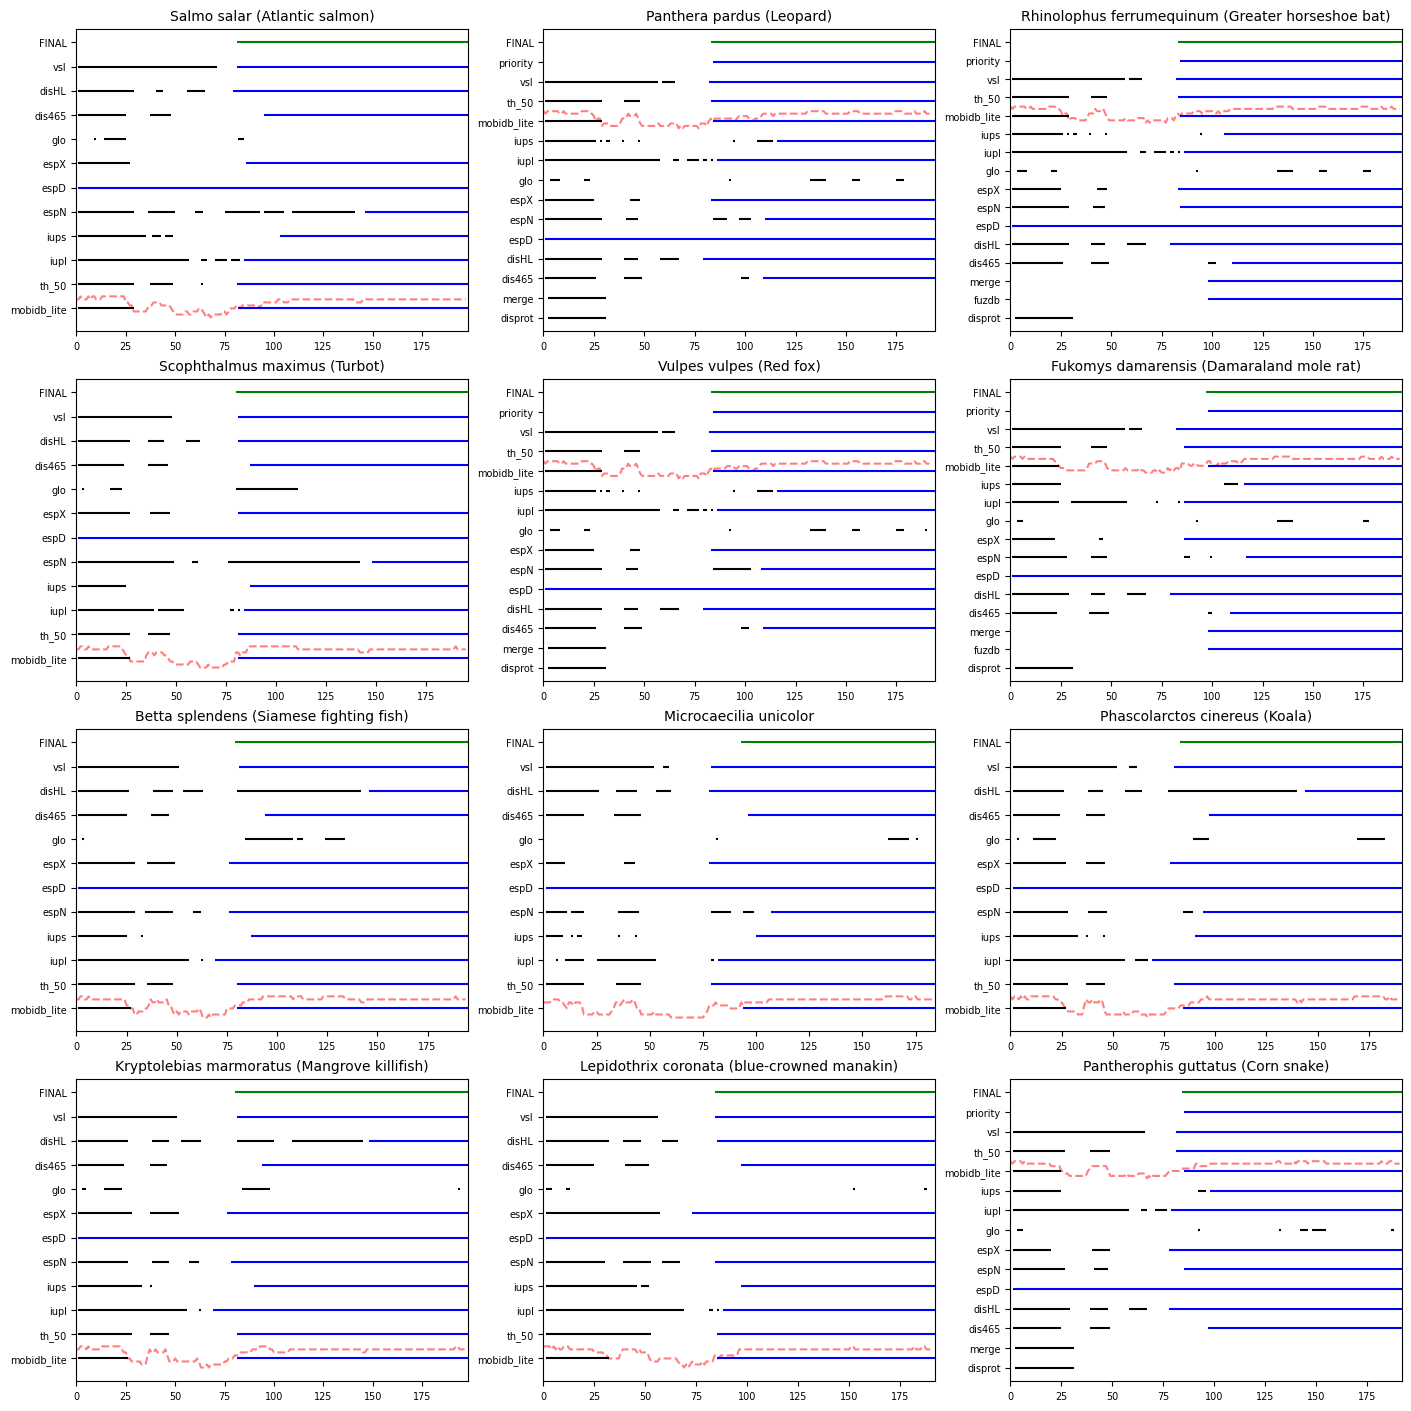

In [19]:
# Sampling uniprot IDs
metadata = analyse_utils.load_metadata(f'exp/{experiment}/{experiment}.json')
metadata = metadata.sample(12)
metadata.set_index('uniprot_id', inplace=True, drop=False)
uniprot_ids = metadata.uniprot_id

# Building fig layout
cols = int(np.floor(np.sqrt(len(uniprot_ids))))
rows = len(uniprot_ids)//cols
fig, axes = plt.subplots(rows, cols, constrained_layout=True)

# Looping over uniprot IDs
for i, uid in enumerate(uniprot_ids):
    if rows == 1:
        ax = axes
    elif cols == 1:
        ax = axes[i]
    else:
        ax = axes[i%rows,i//rows]

    # Querying MobiDB
    response = requests.get(f"https://mobidb.org/api/download", params={'acc': [uid]}).json()
    disorder_regions = {k.split('-')[-1]: response[k]['regions'] for k in response if 'disorder' in k and 'regions' in response[k]}
    disorder_scores = {k.split('-')[-1]: response[k]['scores'] for k in response if 'disorder' in k and 'scores' in response[k]}

    # Plotting MobiDB data
    for j, k in enumerate(disorder_regions):
        # Plotting scores
        if k in disorder_scores:
            ax.plot(range(len(response['sequence'])), [v-0.5+j for v in disorder_scores[k]], 'r--', alpha=0.5)
        # Plotting predicted IDRs
        for region in disorder_regions[k]:
            start, end = region

            # Painting C-terminal IDRs
            if end == len(response['sequence']):
                c = 'b'
            else:
                c = 'k'
                
            ax.hlines(j, start, end, c)

    # Plotting annoted region
    start, end = metadata.location[uid].split(':')
    ax.hlines(len(disorder_regions), int(start), int(end), 'g')

    # Setting labels
    ax.set_xlim(0, len(response['sequence']))
    ax.set_yticks(range(len(disorder_regions)+1))
    ax.set_yticklabels([*disorder_regions.keys(), 'FINAL'])
    ax.tick_params(labelsize=7)
    ax.set_title(metadata.loc[uid,'species'], size=10)

fig.set_size_inches(14, 14)
fig.show()